# Apply NB using BoW and TF-IDF on Text Data

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li>
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB`
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import metrics

import re
from tqdm import tqdm
import os

from collections import Counter

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [ ]:
# Mounting Google Drive in Google Colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data from google drive

filepath = '/content/drive/My Drive/Colab Notebooks/Assignments/As8_Apply Naive Bayes on Donors Choose dataset/'
data = pd.read_csv(filepath + 'preprocessed_data.csv')
data.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [ ]:
# Splitting the data into independent features and dependent feature

X = data.drop(['project_is_approved'], axis=1) # independent input features
y = data['project_is_approved']   # dependent Target variable

print(X.shape, y.shape)

(109248, 8) (109248,)


In [ ]:
# Splitting x and y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.1, stratify = y)

print('Train data shape:', X_train.shape, y_train.shape)  # train data
print('Test data shape: ', X_test.shape, y_test.shape)    # test data

Train data shape: (98323, 8) (98323,)
Test data shape:  (10925, 8) (10925,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [ ]:
def vectorize_essay(vectorizer, train_data, test_data, num_max_features= None):
    '''
    This function fits on train data and transforms on both train and test TEXT data for given maximum number of features.
    It returns vectorized form of train and test TEXT data along with list of feature names.
    '''
    # a feature is considered if it is repeated in atleast 10 docs
    # consecutive words upto 4 is considered
    vec = vectorizer(min_df = 10, ngram_range=(1,4), max_features = num_max_features)

    x_train_vectorized = vec.fit_transform(train_data)  # fit and transform train data
    x_test_vectorized = vec.transform(test_data)        # Transform test data

    features = vec.get_feature_names_out()   # List of feature names

    return x_train_vectorized, x_test_vectorized, list(features)

In [ ]:
# Vectorization for feature essay
print("Vectorization of feature 'essay'")
print('\n')

vectorizer = CountVectorizer
# set1 : preprocessed_eassay (BOW with 5000 features)
X_train_essay_bow_5k, X_test_essay_bow_5k, features_essay_bow_5k = vectorize_essay(vectorizer, X_train['essay'], X_test['essay'], 5000)
print('After BoW vectorization')
print('Train data with', len(features_essay_bow_5k) ,'features  : ', X_train_essay_bow_5k.shape, y_train.shape)
print('Test data with', len(features_essay_bow_5k) ,'features   : ', X_test_essay_bow_5k.shape, y_test.shape)

# set2 : preprocessed_eassay (BOW with 50000 features)
X_train_essay_bow_max, X_test_essay_bow_max, features_essay_bow_max = vectorize_essay(vectorizer, X_train['essay'], X_test['essay'],50000)
print('Train data with', len(features_essay_bow_max) ,'features  : ', X_train_essay_bow_max.shape, y_train.shape)
print('Test data with', len(features_essay_bow_max) ,'features   : ', X_test_essay_bow_max.shape, y_test.shape)
print('='*70)

vectorizer = TfidfVectorizer
# set3 : preprocessed_eassay (TFIDF with 5000 features)
X_train_essay_tfidf_5k, X_test_essay_tfidf_5k, features_essay_tfidf_5k = vectorize_essay(vectorizer, X_train['essay'], X_test['essay'], 5000)
print('After Tfidf vectorization')
print('Train data with', len(features_essay_tfidf_5k) ,'features  : ', X_train_essay_tfidf_5k.shape, y_train.shape)
print('Test data with', len(features_essay_tfidf_5k) ,'features   : ', X_test_essay_tfidf_5k.shape, y_test.shape)

# set4 : preprocessed_eassay (TFIDF with 50000 features)
X_train_essay_tfidf_max, X_test_essay_tfidf_max, features_essay_tfidf_max = vectorize_essay(vectorizer, X_train['essay'], X_test['essay'],50000)
print('Train data with', len(features_essay_tfidf_max) ,'features  : ', X_train_essay_tfidf_max.shape, y_train.shape)
print('Test data with', len(features_essay_tfidf_max) ,'features   : ', X_test_essay_tfidf_max.shape, y_test.shape)

Vectorization of feature 'essay'


After BoW vectorization
Train data with 5000 features  :  (98323, 5000) (98323,)
Test data with 5000 features   :  (10925, 5000) (10925,)
Train data with 50000 features  :  (98323, 50000) (98323,)
Test data with 50000 features   :  (10925, 50000) (10925,)
After Tfidf vectorization
Train data with 5000 features  :  (98323, 5000) (98323,)
Test data with 5000 features   :  (10925, 5000) (10925,)
Train data with 50000 features  :  (98323, 50000) (98323,)
Test data with 50000 features   :  (10925, 50000) (10925,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### Encoding Categorical features

In [ ]:
def ohe_categorical(train_data, test_data):
    '''
    This function one hot encodes the categorical feature.
    It fits on train data and transforms on both train and test data.
    It returns transformed train, test data and feature names
    '''
    vectorizer = CountVectorizer()
    x_train_ohe = vectorizer.fit_transform(train_data)
    x_test_ohe = vectorizer.transform(test_data)

    features_ohe = vectorizer.get_feature_names_out()  # list of feature names

    return x_train_ohe, x_test_ohe, list(features_ohe)

In [ ]:
# feature school_state
X_train_state_ohe, X_test_state_ohe, features_state_ohe = ohe_categorical(X_train['school_state'], X_test['school_state'])
print("Feature school_state after vectorization")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(features_state_ohe)
print("="*100)

# feature teacher_prefix
X_train_teacher_ohe, X_test_teacher_ohe, features_teacher_ohe = ohe_categorical(X_train['teacher_prefix'], X_test['teacher_prefix'])
print("Feature teacher_prefix after vectorization")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(features_teacher_ohe)
print("="*100)

# feature project_grade_category
X_train_grade_ohe, X_test_grade_ohe, features_grade_ohe = ohe_categorical(X_train['project_grade_category'], X_test['project_grade_category'])
print("Feature project_grade_category after vectorization")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(features_grade_ohe)
print("="*100)

# feature clean_categories
X_train_categories_ohe, X_test_categories_ohe, features_categories_ohe = ohe_categorical(X_train['clean_categories'], X_test['clean_categories'])
print("Feature clean_categories after vectorization")
print(X_train_categories_ohe.shape, y_train.shape)
print(X_test_categories_ohe.shape, y_test.shape)
print(features_categories_ohe)
print("="*100)

# feature clean_subcategories
X_train_subcategories_ohe, X_test_subcategories_ohe, features_subcategories_ohe = ohe_categorical(X_train['clean_subcategories'], X_test['clean_subcategories'])
print("Feature clean_subcategories after vectorization")
print(X_train_subcategories_ohe.shape, y_train.shape)
print(X_test_subcategories_ohe.shape, y_test.shape)
print(features_subcategories_ohe)

Feature school_state after vectorization
(98323, 51) (98323,)
(10925, 51) (10925,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
Feature teacher_prefix after vectorization
(98323, 5) (98323,)
(10925, 5) (10925,)
['dr', 'mr', 'mrs', 'ms', 'teacher']
Feature project_grade_category after vectorization
(98323, 4) (98323,)
(10925, 4) (10925,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
Feature clean_categories after vectorization
(98323, 9) (98323,)
(10925, 9) (10925,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
Feature clean_subcategories after vectorization
(98323, 30) (98323,)
(10925, 30) (10925,)
['appliedscience

### Encoding Numerical Features

In [ ]:
from sklearn.preprocessing import Normalizer, MinMaxScaler

# normalizing feature price row wise
normalizer = MinMaxScaler()
X_train_price_norm = normalizer.fit_transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))


print("Feature 'price' after vectorization")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

# normalizing feature teacher_number_of_previously_posted_projects row wise
X_train_numprojects_norm = normalizer.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_numprojects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print("Feature 'teacher_number_of_previously_posted_projects' after vectorization")
print(X_train_numprojects_norm.shape, y_train.shape)
print(X_test_numprojects_norm.shape, y_test.shape)

Feature 'price' after vectorization
(98323, 1) (98323,)
(10925, 1) (10925,)
Feature 'teacher_number_of_previously_posted_projects' after vectorization
(98323, 1) (98323,)
(10925, 1) (10925,)


### Concatenating all features

In [ ]:
# Stacking training and test data

from scipy.sparse import hstack

# Set 1: categorical, numerical features + preprocessed_eassay (BOW with 5k features)
X_bow_5k_tr = hstack((X_train_essay_bow_5k, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_price_norm, X_train_numprojects_norm)).tocsr()
X_bow_5k_te = hstack((X_test_essay_bow_5k, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_price_norm, X_test_numprojects_norm)).tocsr()

# Set 2: categorical, numerical features + preprocessed_eassay (BOW with max features)
X_bow_max_tr = hstack((X_train_essay_bow_max, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_price_norm, X_train_numprojects_norm)).tocsr()
X_bow_max_te = hstack((X_test_essay_bow_max, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_price_norm, X_test_numprojects_norm)).tocsr()

print("Final Data matrix with BOW representation of essay")
print('for 5000 features  :', X_bow_5k_tr.shape, y_train.shape)
print('for 5000 features  :', X_bow_5k_te.shape, y_test.shape)
print('for max features   :', X_bow_max_tr.shape, y_train.shape)
print('for max features   :', X_bow_max_te.shape, y_test.shape)
print("="*100)

# Set 3: categorical, numerical features + preprocessed_eassay (Tf-IDF with 5k features)
X_tfidf_5k_tr = hstack((X_train_essay_tfidf_5k, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_price_norm, X_train_numprojects_norm)).tocsr()
X_tfidf_5k_te = hstack((X_test_essay_tfidf_5k, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_price_norm, X_test_numprojects_norm)).tocsr()

# Set 4: categorical, numerical features + preprocessed_eassay (Tf-IDF with max features)
X_tfidf_max_tr = hstack((X_train_essay_tfidf_max, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_price_norm, X_train_numprojects_norm)).tocsr()
X_tfidf_max_te = hstack((X_test_essay_tfidf_max, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_price_norm, X_test_numprojects_norm)).tocsr()

print("Final Data matrix with tfidf representation of essay")
print('for 5000 features  :', X_tfidf_5k_tr.shape, y_train.shape)
print('for 5000 features  :', X_tfidf_5k_te.shape, y_test.shape)
print('for max features   :', X_tfidf_max_tr.shape, y_train.shape)
print('for max features   :', X_tfidf_max_te.shape, y_test.shape)

Final Data matrix with BOW representation of essay
for 5000 features  : (98323, 5101) (98323,)
for 5000 features  : (10925, 5101) (10925,)
for max features   : (98323, 50101) (98323,)
for max features   : (10925, 50101) (10925,)
Final Data matrix with tfidf representation of essay
for 5000 features  : (98323, 5101) (98323,)
for 5000 features  : (10925, 5101) (10925,)
for max features   : (98323, 50101) (98323,)
for max features   : (10925, 50101) (10925,)


In [ ]:
# Feature set 1: categorical, numerical features + preprocessed_eassay (BOW with 5000 features)
feature_names_set1 = features_essay_bow_5k + features_state_ohe + features_teacher_ohe + features_grade_ohe + features_categories_ohe + features_subcategories_ohe + ['price', 'teacher_number_of_previously_posted_projects']

# Feature set 2: categorical, numerical features + preprocessed_eassay (BOW with max features)
feature_names_set2 = features_essay_bow_max + features_state_ohe + features_teacher_ohe + features_grade_ohe + features_categories_ohe + features_subcategories_ohe + ['price', 'teacher_number_of_previously_posted_projects']

# Feature set 3: categorical, numerical features + preprocessed_eassay (TFIDF with 5000 features)
feature_names_set3 = features_essay_tfidf_5k + features_state_ohe + features_teacher_ohe + features_grade_ohe + features_categories_ohe + features_subcategories_ohe + ['price', 'teacher_number_of_previously_posted_projects']

# Feature set 4: categorical, numerical features + preprocessed_eassay (TFIDF with max features)
feature_names_set4 = features_essay_tfidf_max + features_state_ohe + features_teacher_ohe + features_grade_ohe + features_categories_ohe + features_subcategories_ohe + ['price', 'teacher_number_of_previously_posted_projects']

print('total number of features for BoW representation of essay with 5000 and max features respectively   : ', len(feature_names_set1), len(feature_names_set2))
print('total numbre of features for tfidf representation of essay with 5000 and max features respectively : ', len(feature_names_set3), len(feature_names_set4))

total number of features for BoW representation of essay with 5000 and max features respectively   :  5101 50101
total numbre of features for tfidf representation of essay with 5000 and max features respectively :  5101 50101


In [ ]:
# Concatenation that are useful ahead

x_train_data_sets = [X_bow_5k_tr, X_bow_max_tr, X_tfidf_5k_tr, X_tfidf_max_tr]  # train data
x_test_data_sets = [X_bow_5k_te, X_bow_max_te, X_tfidf_5k_te, X_tfidf_max_te]   # test data

feature_sets = [feature_names_set1, feature_names_set2, feature_names_set3, feature_names_set4]  # all feature sets
num_features_in_sets = [len(feature_names_set1), len(feature_names_set2), len(feature_names_set3), len(feature_names_set4)] # Num of features in sets

vectorizer = ['BoW', 'BoW', 'TF-IDF', 'TF-IDF']  # Vectorizer

sets_description = ['Set 1: categorical, numerical features + preprocessed_eassay (BOW with 5k features)', \
       'Set 2: categorical, numerical features + preprocessed_eassay (BOW with max features)',\
       'Set 3: categorical, numerical features + preprocessed_eassay (Tf-IDF with 5k features)',\
       'Set 4: categorical, numerical features + preprocessed_eassay (Tf-IDF with max features)']  # Set Description

<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

def optimize_MNB(x_train, y_train, tuning_method, parameters, CV = 5, scoring = 'roc_auc'):
    '''
    This function optimizes MultinomialNB model
    '''

    model = MultinomialNB()
    parameters = parameters
    clf = tuning_method(model, parameters, cv= CV, scoring = scoring, return_train_score = True)
    clf.fit(x_train, y_train)   # Fit on train data

    results = pd.DataFrame.from_dict(clf.cv_results_)  # Cross validation results in dataframe
    results = results.sort_values(['param_alpha'])    # Sort based on alpha values

    optimized_MNB = clf.best_estimator_             # Best parameters of model
    best_alpha = clf.best_estimator_.alpha          # Best alpha
    best_class_prior = clf.best_estimator_.class_prior # Best class_prior
    print('\033[1m', 'Optimized model parameters                : \033[0m', optimized_MNB)
    print('\033[1m AUC score using optimized model on CV data: \033[0m', round(clf.best_score_,3))
    print('\n')

    train_auc = results['mean_train_score']   # Mean of AUC score on CV data [train]
    cv_auc = results['mean_test_score']       # Mean of AUC score on CV data [test]
    # Reference : https://stackoverflow.com/questions/59297543/why-do-i-get-the-loop-of-ufunc-does-not-support-argument-0-of-type-int-error-f
    alpha = results['param_alpha'] .astype('float')

    # Plotting Parameter alpha vs AUC
    plt.figure(figsize = (9,6))
    plt.plot(np.log(alpha), train_auc, label ='Train AUC')   # np.log is applied for readability of graph
    plt.plot(np.log(alpha), cv_auc, label = 'CV AUC')
    plt.scatter(np.log(alpha), train_auc, label = 'Train AUC points')
    plt.scatter(np.log(alpha), cv_auc, label = 'CV AUC points')
    plt.xlabel('log(Parameter : alpha)', fontsize = 12)
    plt.ylabel('AUC', fontsize= 12)
    plt.legend()
    plt.title('Parameter alpha vs AUC plot', fontsize = 14)
    plt.grid(True)
    plt.show()

    return optimized_MNB, best_alpha, best_class_prior

In [ ]:
def AUC_train_test(optimized_model, x_train, y_train, x_test, y_test):
    '''
    This function returns the AUC on train and test data.
    It also plots the ROC curve for both train and test data
    '''
    optimized_model.fit(x_train, y_train)  # optimized model is fitted on train data

    y_tr_proba = optimized_model.predict_proba(x_train)[:,-1] # Prediction on train data
    y_te_proba = optimized_model.predict_proba(x_test)[:,-1]  # prediction on test data
    y_te_pred = optimized_model.predict(x_test)

    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_tr_proba) # fpr, tpr and threshold on train data
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_te_proba)  # fpr, tpr and threshold on train data

    train_auc = round(auc(train_fpr, train_tpr),3) # AUC on train data
    test_auc = round(auc(test_fpr, test_tpr),3)  # Auc on test data

    # Plotting ROC curve for train and test data
    print('\n')
    plt.figure(figsize=(9,6))
    plt.plot(train_fpr, train_tpr, label = 'train AUC = '+ str(train_auc))
    plt.plot(test_fpr, test_tpr, label = 'test AUC = ' + str(test_auc))
    plt.xlabel('fpr', fontsize= 12)
    plt.ylabel('tpr', fontsize= 12)
    plt.legend()
    plt.title('ROC curve', fontsize = 14)
    plt.grid(True)
    plt.show()

    print('\n')
    # Confusion matrix with predicted and original labels of test data points
    # Reference: https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
    sns.heatmap(confusion_matrix(y_test, y_te_pred), annot=True, fmt='d', cmap= 'Blues')
    plt.xlabel('Predicted', fontsize = 12)
    plt.ylabel('Actual', fontsize = 12)
    plt.title('Confusion matrix heatmap on test data', fontsize = 14)
    plt.show()

    return train_auc, test_auc

In [ ]:
# Top 20 features for each class
# Reference: https://imgur.com/mWvE7gj
def top_features(feature_set, optimized_model, num=20):
    '''
    This function returns the top 20 features unless specified for both the positive and negative class
    '''

    class_0 = np.argsort(optimized_model.feature_log_prob_[0])[::-1][:num]  # Negative class
    class_1 = np.argsort(optimized_model.feature_log_prob_[1])[::-1][:num]  # Positive class

    top_features_class_0 = [feature_set[ind] for ind in class_0]   # top features of negative class
    top_features_class_1 = [feature_set[ind] for ind in class_1]   # top features of positive class

    return top_features_class_0, top_features_class_1

 Set 1: categorical, numerical features + preprocessed_eassay (BOW with 5k features) 
 Optimized model parameters                :  MultinomialNB(alpha=1e-05)
 AUC score using optimized model on CV data:  0.691




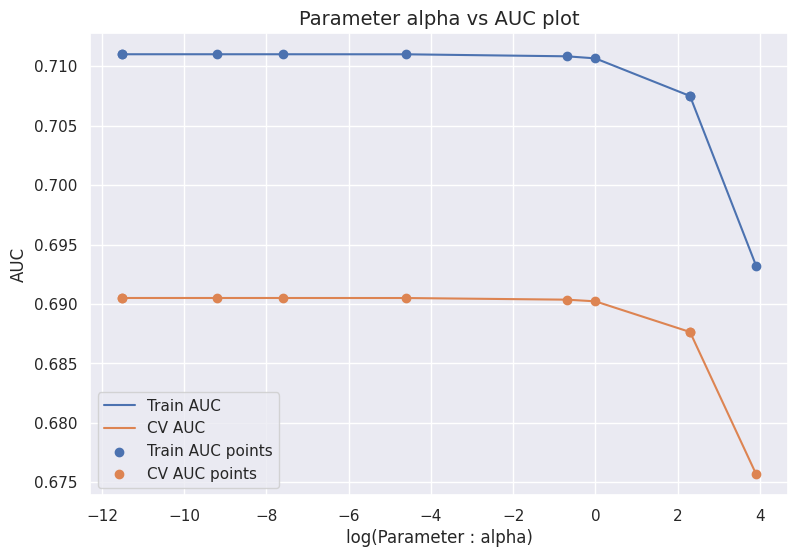

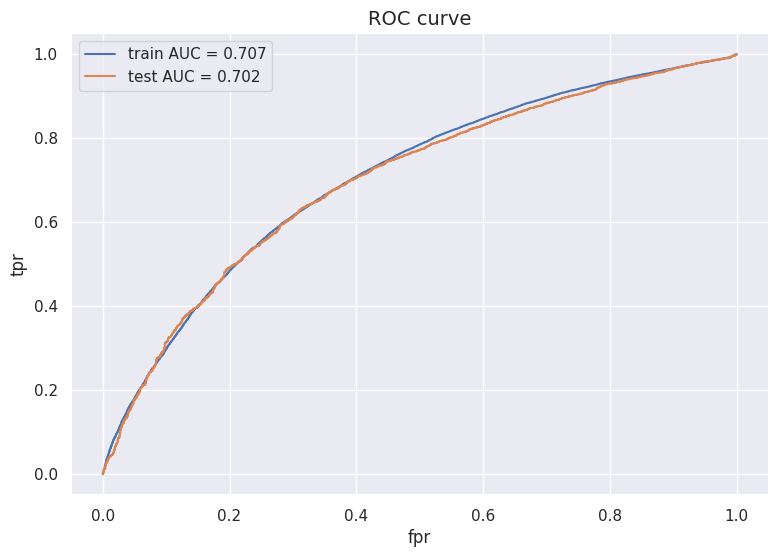

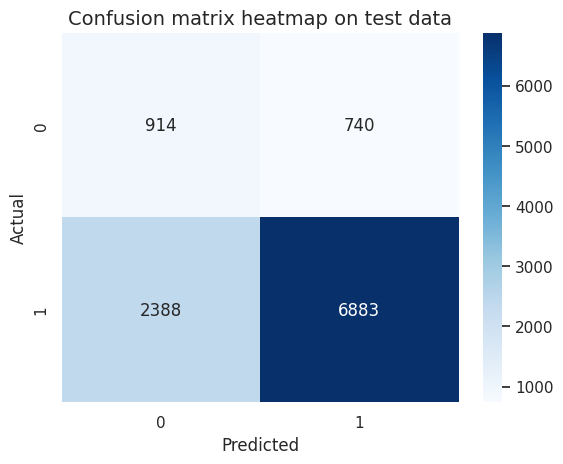



 Top features from given feature set for class_0:  
 ['students', 'school', 'learning', 'my', 'classroom', 'not', 'learn', 'they', 'help', 'the', 'my students', 'nannan', 'many', 'we', 'need', 'work', 'come', 'love', 'reading', 'able']
 Top features from given feature set for class_1:  
 ['students', 'school', 'my', 'learning', 'classroom', 'the', 'not', 'they', 'my students', 'learn', 'help', 'many', 'nannan', 'we', 'need', 'work', 'reading', 'use', 'love', 'day']


 Set 2: categorical, numerical features + preprocessed_eassay (BOW with max features) 
 Optimized model parameters                :  MultinomialNB(alpha=0.01)
 AUC score using optimized model on CV data:  0.701




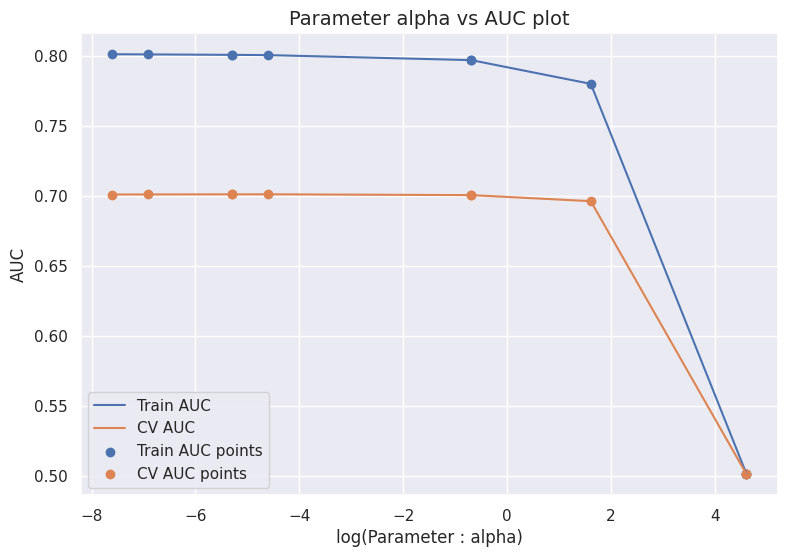

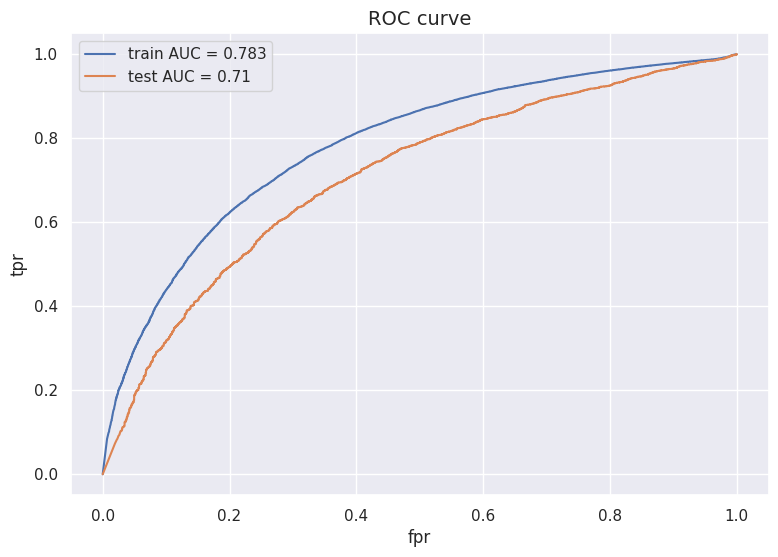

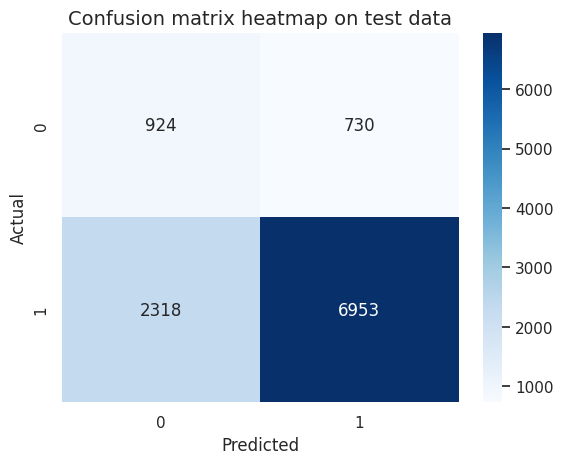



 Top features from given feature set for class_0:  
 ['students', 'school', 'learning', 'my', 'classroom', 'not', 'learn', 'they', 'help', 'the', 'my students', 'nannan', 'many', 'we', 'need', 'work', 'come', 'love', 'reading', 'able']
 Top features from given feature set for class_1:  
 ['students', 'school', 'my', 'learning', 'classroom', 'the', 'not', 'they', 'my students', 'learn', 'help', 'many', 'nannan', 'we', 'need', 'work', 'reading', 'use', 'love', 'day']


 Set 3: categorical, numerical features + preprocessed_eassay (Tf-IDF with 5k features) 
 Optimized model parameters                :  MultinomialNB(alpha=1e-05)
 AUC score using optimized model on CV data:  0.673




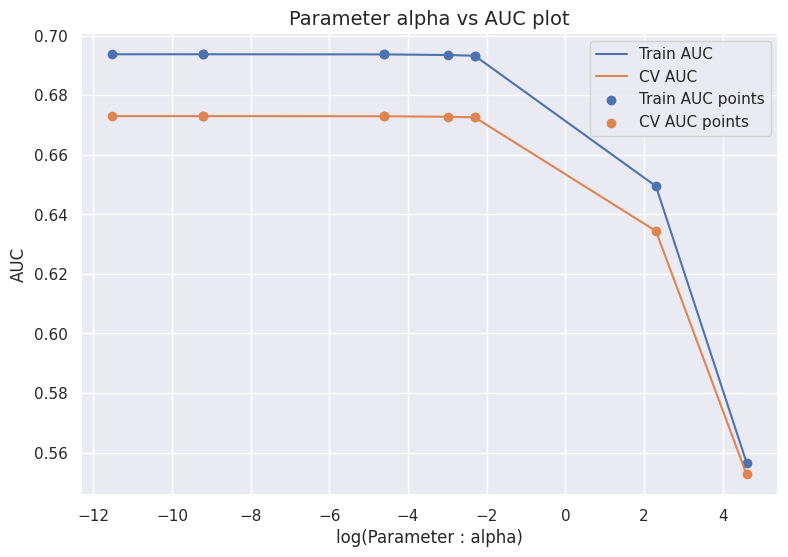

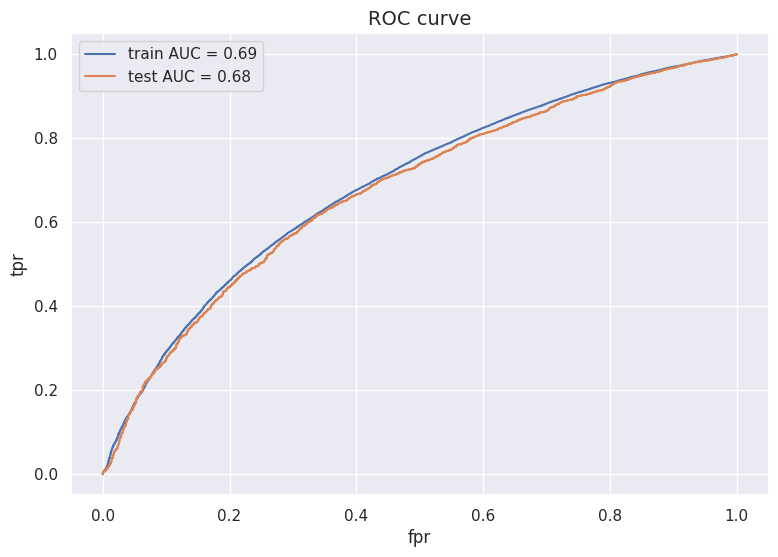

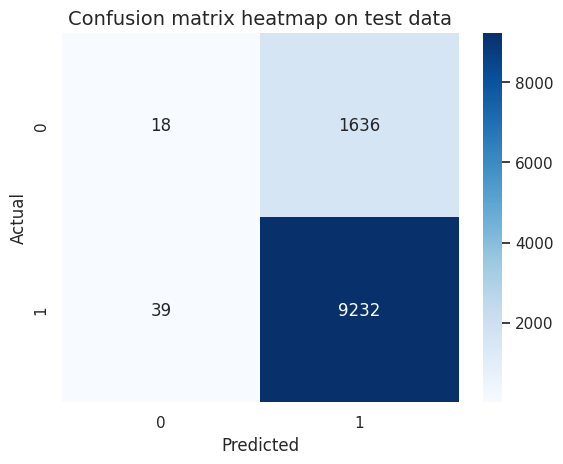



 Top features from given feature set for class_0:  
 ['mrs', 'literacy_language', 'grades_prek_2', 'math_science', 'ms', 'grades_3_5', 'mathematics', 'literacy', 'literature_writing', 'grades_6_8', 'specialneeds', 'specialneeds', 'ca', 'health_sports', 'appliedlearning', 'students', 'appliedsciences', 'grades_9_12', 'mr', 'music_arts']
 Top features from given feature set for class_1:  
 ['mrs', 'literacy_language', 'grades_prek_2', 'math_science', 'ms', 'grades_3_5', 'literacy', 'mathematics', 'literature_writing', 'grades_6_8', 'ca', 'health_sports', 'students', 'specialneeds', 'specialneeds', 'appliedlearning', 'grades_9_12', 'mr', 'appliedsciences', 'health_wellness']


 Set 4: categorical, numerical features + preprocessed_eassay (Tf-IDF with max features) 
 Optimized model parameters                :  MultinomialNB(alpha=0.001)
 AUC score using optimized model on CV data:  0.691




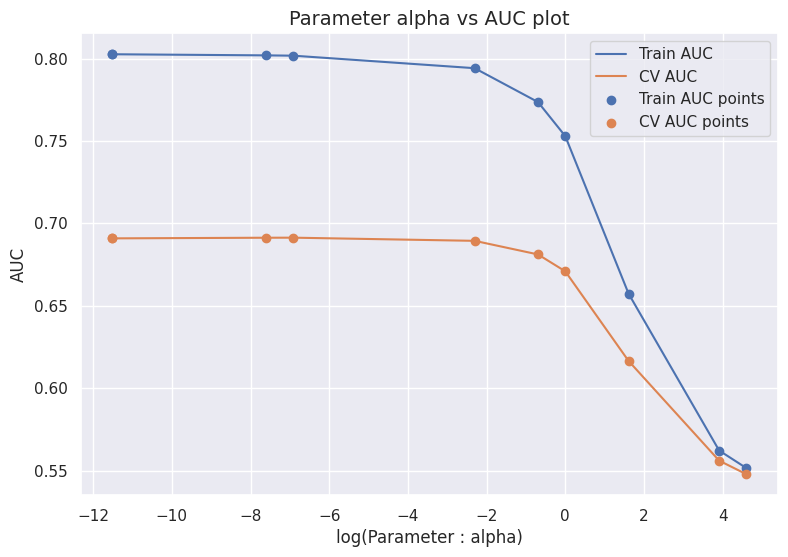

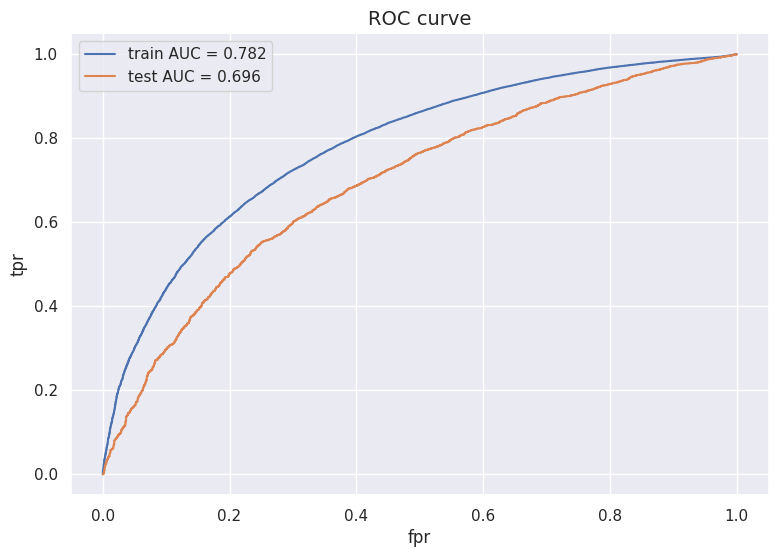

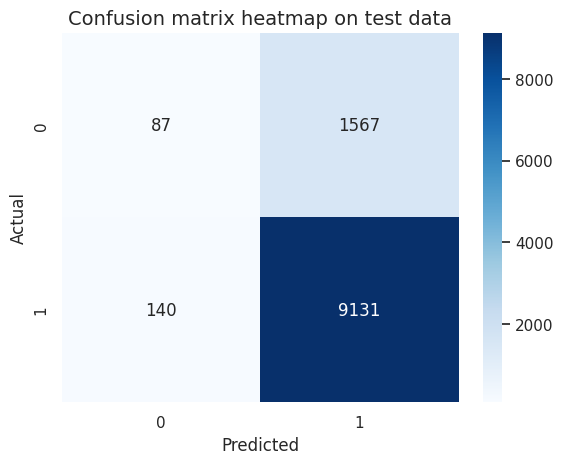



 Top features from given feature set for class_0:  
 ['mrs', 'literacy_language', 'grades_prek_2', 'math_science', 'ms', 'grades_3_5', 'mathematics', 'literacy', 'literature_writing', 'grades_6_8', 'specialneeds', 'specialneeds', 'ca', 'health_sports', 'appliedlearning', 'appliedsciences', 'grades_9_12', 'mr', 'music_arts', 'health_wellness']
 Top features from given feature set for class_1:  
 ['mrs', 'literacy_language', 'grades_prek_2', 'math_science', 'ms', 'grades_3_5', 'literacy', 'mathematics', 'literature_writing', 'grades_6_8', 'ca', 'health_sports', 'specialneeds', 'specialneeds', 'appliedlearning', 'grades_9_12', 'mr', 'appliedsciences', 'health_wellness', 'music_arts']




In [ ]:
# Input to functions  - parameters and tuning method
params = {'alpha' : [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100], 'class_prior' : [None, [0.5,0.5]]}
tuning_method = RandomizedSearchCV  # Or GridSearchCV

from prettytable import PrettyTable
summary = PrettyTable(field_names = ['Vectorizer', 'Num of features', 'Parameter_Alpha', 'Parameter_classprior', 'train_auc', 'test_auc'])

for ind in range(len(x_train_data_sets)):

    # Reference: https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
    print('\033[1m', sets_description[ind], '\033[0m')

    optimized_MNB, best_alpha, best_class_prior = optimize_MNB(x_train_data_sets[ind], y_train, tuning_method, params)  # Optimize model
    train_auc, test_auc = AUC_train_test(optimized_MNB, x_train_data_sets[ind], y_train, x_test_data_sets[ind], y_test) # AUC score on train and test data
    top_features_class_0, top_features_class_1 = top_features(feature_sets[ind], optimized_MNB)  # top features of negative and positive classes
    print('\n')
    print('\033[1m Top features from given feature set for class_0: \033[0m', '\n', top_features_class_0)
    print('\033[1m Top features from given feature set for class_1: \033[0m', '\n', top_features_class_1)
    print('\n', '='*200, '\n')
    summary.add_row([vectorizer[ind], num_features_in_sets[ind], best_alpha, best_class_prior, train_auc, test_auc])  # adds row to summary table

### <h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [ ]:
# print summary table
print('\033[1m Summary of models \033[0m')
print(summary)

 Summary of models 
+------------+-----------------+-----------------+----------------------+-----------+----------+
| Vectorizer | Num of features | Parameter_Alpha | Parameter_classprior | train_auc | test_auc |
+------------+-----------------+-----------------+----------------------+-----------+----------+
|    BoW     |       5101      |      1e-05      |         None         |   0.707   |  0.702   |
|    BoW     |      50101      |       0.01      |         None         |   0.783   |   0.71   |
|   TF-IDF   |       5101      |      1e-05      |         None         |    0.69   |   0.68   |
|   TF-IDF   |      50101      |      0.001      |         None         |   0.782   |  0.696   |
+------------+-----------------+-----------------+----------------------+-----------+----------+


Conclusion from summary table:

    1. We see that BoW performs slightly better than Tfidf on this dataset
    2. As number of features is maximum, the auc score on train data is much higher compared to auc score on test data. The model overfits